In [1]:
import geopandas as gpd
import pandas as pd
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point, Polygon, MultiPolygon
import math
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import numpy as np

In [82]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)

Connected successfully.


In [3]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [4]:
stops_df = pd.read_csv('Stops.txt')
stops_df['geom'] = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)
stops_df = stops_df.drop(columns=['stop_lon', 'stop_lat'])  # removing the old latitude/longitude fields
stops_df['geom'] = stops_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=4326))
conn.execute('DROP TABLE IF EXISTS stops;')
conn.execute("""
CREATE TABLE stops (
    stop_id VARCHAR(10),
    stop_code VARCHAR(10),
    stop_name VARCHAR(100),
    location_type FLOAT,
    parent_station VARCHAR(10),
    wheelchair_boarding INTEGER,
    platform_code VARCHAR(10),
    geom GEOMETRY(POINT, 4326)
);
""")
conn.execute('CREATE INDEX stops_geom ON stops USING GIST (geom);')

print(stops_df.shape)

stops_df.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4326)})
query(conn, "select * from stops").head()

/Users/lxhao/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  """


(114718, 8)


,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,None,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,None,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,None,Central Station,1.0,None,0,None,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,None,Redfern Station,1.0,None,0,None,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,None,0101000020E6100000DCF9333D5DE662403DFA6B9D58F2...


In [5]:
polls_df = pd.read_csv('PollingPlaces2019.csv')
polls_df.dropna(inplace=True)
polls_df['geom'] = gpd.points_from_xy(polls_df.longitude, polls_df.latitude)
polls_df = polls_df.drop(columns=['longitude', 'latitude'])  # removing the old latitude/longitude fields
polls_df['geom'] = polls_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=4326))
polls_df = polls_df.drop(columns="the_geom")
conn.execute('DROP TABLE IF EXISTS polls;')
conn.execute("""
CREATE TABLE polls (
    fid VARCHAR(100),
    geom GEOMETRY(POINT,4326)
);
""")
conn.execute('CREATE INDEX polls_geom ON polls USING GIST (geom);')
print(polls_df.shape)

polls_df = polls_df[['FID', 'geom']]
polls_df.columns = ['fid', 'geom']
polls_df.to_sql('polls', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4326)})
query(conn, "select * from polls").head()

(35, 15)


,fid,geom
0,aec_federal_election_polling_places_2019.fid-4...,0101000020E6100000435C94349AE66240D7AB23A2F3F0...
1,aec_federal_election_polling_places_2019.fid-4...,0101000020E6100000435C94349AE66240D7AB23A2F3F0...
2,aec_federal_election_polling_places_2019.fid-4...,0101000020E6100000CE2445BFD1E56240131F44D72AE6...
3,aec_federal_election_polling_places_2019.fid-4...,0101000020E6100000435C94349AE66240D7AB23A2F3F0...
4,aec_federal_election_polling_places_2019.fid-4...,0101000020E610000041A90716D1E562401926AEBE15E6...


In [6]:
businesses_df = pd.read_csv('Businesses.csv')
conn.execute('DROP TABLE IF EXISTS businesses;')
conn.execute("""
CREATE TABLE businesses (
    industry_code CHAR, 
    industry_name VARCHAR(128),
    sa2_code VARCHAR(128),
    sa2_name VARCHAR(128),
    total_businesses INTEGER
);
""")
conn.execute('CREATE INDEX businesses_sa2_code ON businesses (sa2_code);')
print(businesses_df.shape)
businesses_df = businesses_df[['industry_code', 'industry_name', 'sa2_code', 'sa2_name', 'total_businesses']]
businesses_df.to_sql('businesses', conn, if_exists='append', index=False)
query(conn, "select * from businesses").head()

(12217, 11)


,industry_code,industry_name,sa2_code,sa2_name,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16


In [7]:
population_df = pd.read_csv('Population.csv')
population_df['young_people'] = population_df['0-4_people'] + population_df['5-9_people'] + \
                                population_df['10-14_people'] + population_df['15-19_people']
population_df = population_df[['young_people', 'sa2_code', 'sa2_name', 'total_people']]

print(population_df.shape)

conn.execute('DROP TABLE IF EXISTS sa2_population;')
conn.execute("""
CREATE TABLE sa2_population (
    sa2_code VARCHAR(32),
    sa2_name VARCHAR(64),
    young_people INTEGER,
    total_people INTEGER
);
""")
conn.execute('CREATE INDEX population_sa2_code ON sa2_population (sa2_code);')
population_df.to_sql('sa2_population', conn, if_exists='append', index=False)
query(conn, "select * from sa2_population").head()

(373, 4)


,sa2_code,sa2_name,young_people,total_people
0,102011028,Avoca Beach - Copacabana,2121,7530
1,102011029,Box Head - MacMasters Beach,2471,11052
2,102011030,Calga - Kulnura,961,4748
3,102011031,Erina - Green Point,3205,14803
4,102011032,Gosford - Springfield,4364,21346


In [8]:
income_df = pd.read_csv('Income.csv')
income_df = income_df.replace('np', np.nan)
print(income_df.shape)

income_df.dropna(inplace=True)
conn.execute('DROP TABLE IF EXISTS income;')
conn.execute("""
CREATE TABLE income (
    sa2_code VARCHAR(64),
    sa2_name VARCHAR(64),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);
""")
income_df.to_sql('income', conn, if_exists='append', index=False)
query(conn, "select * from income").head()

(576, 6)


,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426,50,44246,61745
1,101021008,Karabar,5128,42,62946,67345
2,101021009,Queanbeyan,6778,39,61724,67276
3,101021010,Queanbeyan - East,3360,40,64010,71770
4,101021011,Queanbeyan Region,13502,44,74042,85303


In [9]:
school_primary = gpd.read_file('catchments/catchments_primary.shp')

school_secondary = gpd.read_file('catchments/catchments_secondary.shp')

school_future = gpd.read_file('catchments/catchments_future.shp')

schools = school_primary.append(school_secondary).append(school_future)

print(school_primary.shape)
print(school_secondary.shape)
print(school_future.shape)

(1662, 19)
(436, 19)
(30, 18)


In [10]:
schools.dropna(axis=0,subset = ["geometry"]) 
schools['geom'] = schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4326))  # applying the function
schools.columns = schools.columns.map(lambda x: x.lower())
print(schools.shape)
print(schools.columns)
schools = schools[['geom', 'use_id']]

conn.execute('DROP TABLE IF EXISTS schools')
conn.execute("""
CREATE TABLE schools (
    use_id VARCHAR(4),
    geom GEOMETRY(MULTIPOLYGON, 4326)
);
""")
conn.execute('CREATE INDEX schools_geom ON schools USING GIST (geom);')
schools.to_sql('schools', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
query(conn, "select * from schools").head()

(2128, 20)
Index(['use_id', 'catch_type', 'use_desc', 'add_date', 'kindergart', 'year1',
       'year2', 'year3', 'year4', 'year5', 'year6', 'year7', 'year8', 'year9',
       'year10', 'year11', 'year12', 'priority', 'geometry', 'geom'],
      dtype='object')


,use_id,geom
0,2838,0106000020E61000000100000001030000000100000078...
1,2404,0106000020E610000001000000010300000001000000BE...
2,4393,0106000020E61000000100000001030000000100000065...
3,4405,0106000020E61000000100000001030000000100000048...
4,1921,0106000020E610000001000000010300000001000000D2...


In [11]:
sa2 = gpd.read_file('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
sa2 = sa2[sa2['GCC_NAME21']=='Greater Sydney'].copy()
sa2.dropna(inplace=True)
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4326))  # applying the function
print(sa2.shape)
print(sa2.columns)

sa2 = sa2[['SA2_CODE21', 'SA2_NAME21', 'geom']]
sa2.columns = ['sa2_code', 'sa2_name', 'geom']
conn.execute('DROP TABLE IF EXISTS sa2')

conn.execute("""
CREATE TABLE sa2 (
    sa2_code VARCHAR(64),
    sa2_name VARCHAR(64),
    geom GEOMETRY(MULTIPOLYGON, 4326)
);
""")
conn.execute('CREATE INDEX sa2_geom ON sa2 USING GIST (geom);')
conn.execute('CREATE INDEX sa2_code ON sa2 (sa2_code);')
sa2.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
query(conn, "select * from sa2").head()

(373, 18)
Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'geometry', 'geom'],
      dtype='object')


,sa2_code,sa2_name,geom
0,102011028,Avoca Beach - Copacabana,0106000020E6100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0106000020E61000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0106000020E61000000200000001030000000100000085...
3,102011031,Erina - Green Point,0106000020E61000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0106000020E6100000010000000103000000010000007E...


In [12]:
# the first data for Task 3
# https://www.bocsar.nsw.gov.au/Pages/bocsar_datasets/Spatial.aspx
steal_df = gpd.read_file("StealFromDwelling_JanToDec2021.shp")
steal_df['geom'] = steal_df['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=4326))
steal_df.columns = steal_df.columns.map(lambda x: x.lower())
steal_df = steal_df.drop('geometry', axis=1)

conn.execute('DROP TABLE IF EXISTS steal_from_dwelling;')

conn.execute('''
CREATE TABLE steal_from_dwelling (
    objectid    INTEGER,
    geom GEOMETRY(MULTIPOLYGON, 4326)
    )'''
)
conn.execute('CREATE INDEX steal_from_dwelling_geom ON steal_from_dwelling USING GIST (geom);')
steal_df[['objectid', 'geom']].to_sql('steal_from_dwelling', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
query(conn, "select * from steal_from_dwelling").head()

,objectid,geom
0,1,0106000020E61000000100000001030000000100000017...
1,2,0106000020E6100000010000000103000000010000000D...
2,3,0106000020E61000000100000001030000000100000009...
3,4,0106000020E61000000100000001030000000100000011...
4,5,0106000020E6100000010000000103000000010000001F...


In [78]:
# the second data for Task 3
# 
petrol_df = gpd.read_file("datasource-AU_Govt_GA-UoM_AURIN_DB_national_petrol_stations_2012.json")
petrol_df['geom'] = petrol_df['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=4326))
petrol_df.columns = petrol_df.columns.map(lambda x: x.lower())
petrol_df = petrol_df.drop('geometry', axis=1)

print(petrol_df.shape)
print(petrol_df.columns)

(5244, 17)
Index(['id', 'ogc_fid', 'objectid', 'featuretype', 'description', 'class',
       'name', 'operationalstatus', 'owner', 'industryid', 'address', 'suburb',
       'state', 'spatialconfidence', 'revised', 'comment', 'geom'],
      dtype='object')


In [83]:
conn.execute('DROP TABLE IF EXISTS petrol;')

conn.execute('''
CREATE TABLE petrol (
    objectid    INTEGER,
    geom GEOMETRY(MULTIPOLYGON, 4326)
    )'''
)
conn.execute('CREATE INDEX petrol_geom ON petrol USING GIST (geom);')
steal_df[['objectid', 'geom']].to_sql('petrol', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
query(conn, "select * from petrol").head()

,objectid,geom
0,1,0106000020E61000000100000001030000000100000017...
1,2,0106000020E6100000010000000103000000010000000D...
2,3,0106000020E61000000100000001030000000100000009...
3,4,0106000020E61000000100000001030000000100000011...
4,5,0106000020E6100000010000000103000000010000001F...


# Task2

In [84]:
conn.execute("""
-- retail socre
DROP VIEW IF EXISTS view_z_retail;

CREATE VIEW view_z_retail
AS
(SELECT sa2.sa2_code
	, SUM(businesses.total_businesses) / (SUM(total_people) / 1000) AS retail_score
FROM sa2
	JOIN businesses ON sa2.sa2_code = businesses.sa2_code
	JOIN sa2_population p ON sa2.sa2_code = p.sa2_code
WHERE businesses.industry_name = 'Retail Trade'
GROUP BY sa2.sa2_code
HAVING SUM(p.total_people) / 1000 > 0);

-- health socre
DROP VIEW IF EXISTS view_z_health;

CREATE VIEW view_z_health
AS
(SELECT sa2.sa2_code
	, SUM(businesses.total_businesses) / (SUM(total_people) / 1000) AS health_score
FROM sa2
	JOIN businesses ON sa2.sa2_code = businesses.sa2_code
	JOIN sa2_population p ON sa2.sa2_code = p.sa2_code
WHERE businesses.industry_name = 'Health Care and Social Assistance'
GROUP BY sa2.sa2_code
HAVING SUM(p.total_people) / 1000 > 0);

-- stops score
DROP VIEW IF EXISTS view_z_stops;

CREATE VIEW view_z_stops
AS
(SELECT sa2_code, COUNT(*) AS stop_score
FROM sa2
	JOIN stops ON st_contains(sa2.geom, stops.geom)
GROUP BY sa2_code);

-- polls score
DROP VIEW IF EXISTS view_z_polls;

CREATE VIEW view_z_polls
AS
(SELECT sa2_code, COUNT(*) AS poll_score
FROM sa2
	JOIN polls ON st_contains(sa2.geom, polls.geom)
GROUP BY sa2_code);

-- school score
DROP VIEW IF EXISTS view_z_school;

CREATE VIEW view_z_school
AS
(SELECT sa2.sa2_code
	, SUM(st_area(schools.geom)) * 1000 * 1000 / (SUM(sa2_population.young_people) / 1000) AS school_score
FROM sa2
	JOIN schools ON st_intersects(sa2.geom, schools.geom)
	JOIN sa2_population USING (sa2_code)
GROUP BY sa2.sa2_code
HAVING SUM(young_people) / 1000 > 0);

-- steal score
DROP VIEW IF EXISTS view_z_steal;

CREATE VIEW view_z_steal
AS
(SELECT sa2_code
	, SUM(st_area(s.geom)) / MAX(st_area(sa2.geom)) AS steal_score
FROM sa2
	JOIN steal_from_dwelling s ON st_intersects(sa2.geom, s.geom)
GROUP BY sa2_code);

-- petrol score
CREATE VIEW view_z_petrol
AS
(SELECT sa2_code, COUNT(*) AS petrol_score
FROM sa2
	JOIN petrol ON st_contains(sa2.geom, petrol.geom)
GROUP BY sa2_code);

"""
)

In [88]:
scores_data = gpd.read_postgis("""
select sa2.sa2_code,
       sa2.geom,
       retail_score,
       health_score,
       stop_score,
       poll_score,
       school_score,
       steal_score,
       median_income,
       petrol_score
from sa2
         left join view_z_retail using (sa2_code)
         left join view_z_health using (sa2_code)
         left join view_z_stops using (sa2_code)
         left join view_z_polls using (sa2_code)
         left join view_z_school using (sa2_code)
         left join view_z_steal using (sa2_code)
         left join income using (sa2_code)
         left join view_z_petrol using (sa2_code)

""", conn, geom_col= 'geom')
scores_data.head()

,sa2_code,geom,retail_score,health_score,stop_score,poll_score,school_score,steal_score,median_income,petrol_score
0,102011028,"MULTIPOLYGON (((151.41373 -33.46558, 151.41362...",6.0,10.0,127.0,NaN,947.606885,NaN,52450.0,NaN
1,102011029,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507...",4.0,5.0,215.0,NaN,1723.663052,0.009290,48724.0,3.0
2,102011030,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",14.0,10.0,172.0,NaN,30930.192806,0.000042,46228.0,1.0
3,102011031,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288...",10.0,14.0,285.0,NaN,756.107992,0.000371,48292.0,2.0
4,102011032,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342...",8.0,14.0,355.0,NaN,1289.189623,0.325899,51999.0,5.0


In [89]:
sa2_population = query(conn, """
select sa2_code, sum(total_people) as total_people
 from sa2_population
 group by sa2_code
""")
sa2_population

,sa2_code,total_people
0,117031643,12408
1,128011606,8968
2,126021501,15666
3,123011700,11279
4,125041588,13989
...,...,...
368,124021456,7
369,127031522,16619
370,125031480,15794
371,122031432,3798


In [90]:
score_population = pd.merge(scores_data, sa2_population, on='sa2_code')
print(score_population.shape)
score_population = score_population[score_population['total_people'] >= 100]
score_population = score_population[score_population['median_income'] > 0]

print(score_population.shape)
print(score_population.columns)

(373, 11)
(247, 11)
Index(['sa2_code', 'geom', 'retail_score', 'health_score', 'stop_score',
       'poll_score', 'school_score', 'steal_score', 'median_income',
       'petrol_score', 'total_people'],
      dtype='object')


In [94]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))

result_df = score_population.copy()
result_df = result_df.fillna(0)
for col in ['retail_score', 'health_score', 'stop_score',
       'poll_score', 'school_score', 'steal_score', 'petrol_score']:
    result_df[col] = result_df[[col]].apply(max_min_scaler)
    

result_df['zscore'] = result_df['health_score'] + result_df['petrol_score'] + result_df['retail_score'] + result_df['stop_score'] + result_df['poll_score'] + result_df['school_score'] - result_df['steal_score']
result_df.head()

,sa2_code,geom,retail_score,health_score,stop_score,poll_score,school_score,steal_score,median_income,petrol_score,total_people,zscore
0,102011028,"MULTIPOLYGON (((151.41373 -33.46558, 151.41362...",0.084507,0.31250,0.160530,0.0,0.005475,0.000000e+00,52450.0,0.000000,7530,0.563012
1,102011029,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507...",0.056338,0.15625,0.290133,0.0,0.009959,5.750845e-05,48724.0,0.333333,11052,0.845956
2,102011030,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",0.197183,0.31250,0.226804,0.0,0.178711,2.627566e-07,46228.0,0.111111,4748,1.026309
3,102011031,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288...",0.140845,0.43750,0.393225,0.0,0.004369,2.294750e-06,48292.0,0.222222,14803,1.198159
4,102011032,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342...",0.112676,0.43750,0.496318,0.0,0.007449,2.017495e-03,51999.0,0.555556,21346,1.607481


In [92]:
result_df.columns

Index(['sa2_code', 'geom', 'retail_score', 'health_score', 'stop_score',
       'poll_score', 'school_score', 'steal_score', 'median_income',
       'petrol_score', 'total_people', 'zscore'],
      dtype='object')

In [95]:
conn.execute("drop table if exists scores")
conn.execute("""
CREATE TABLE scores (
    sa2_code VARCHAR(32),
    geom GEOMETRY(MULTIPOLYGON, 4326),
    retail_score FLOAT,
    health_score FLOAT,
    stop_score FLOAT,
    poll_score FLOAT,
    school_score FLOAT,
    steal_score FLOAT,
    median_income FLOAT,
    total_people INTEGER,
    petrol_score FLOAT,
    zscore FLOAT
);
""")
result_df['geom'] = result_df['geom'].apply(lambda x: create_wkt_element(geom=x,srid=4326))  # applying the function

result_df.to_sql('scores', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
query(conn, "select * from scores").head()

/Users/lxhao/opt/anaconda3/envs/python3.6/lib/python3.6/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,sa2_code,geom,retail_score,health_score,stop_score,poll_score,school_score,steal_score,median_income,total_people,petrol_score,zscore
0,102011028,0106000020E6100000010000000103000000010000005E...,0.084507,0.31250,0.160530,0.0,0.005475,0.000000e+00,52450.0,7530,0.000000,0.563012
1,102011029,0106000020E61000000100000001030000000100000010...,0.056338,0.15625,0.290133,0.0,0.009959,5.750845e-05,48724.0,11052,0.333333,0.845956
2,102011030,0106000020E61000000200000001030000000100000085...,0.197183,0.31250,0.226804,0.0,0.178711,2.627566e-07,46228.0,4748,0.111111,1.026309
3,102011031,0106000020E61000000100000001030000000100000041...,0.140845,0.43750,0.393225,0.0,0.004369,2.294750e-06,48292.0,14803,0.222222,1.198159
4,102011032,0106000020E6100000010000000103000000010000007E...,0.112676,0.43750,0.496318,0.0,0.007449,2.017495e-03,51999.0,21346,0.555556,1.607481


In [96]:
querys = """
select sa2_code ,
    geom,
    median_income ,
    1 / (1 + EXP(-zscore)) as zscore
from scores
"""

gdf = gpd.read_postgis(querys, conn, geom_col="geom")
gdf

,sa2_code,geom,median_income,zscore
0,102011028,"MULTIPOLYGON (((151.41373 -33.46558, 151.41362...",52450.0,0.637149
1,102011029,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507...",48724.0,0.699718
2,102011030,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",46228.0,0.736200
3,102011031,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288...",48292.0,0.768197
4,102011032,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342...",51999.0,0.833061
...,...,...,...,...
242,128021536,"MULTIPOLYGON (((151.07861 -33.99748, 151.07861...",64428.0,0.767585
243,128021538,"MULTIPOLYGON (((151.05006 -34.02158, 151.05008...",62453.0,0.750611
244,128021607,"MULTIPOLYGON (((150.99568 -34.05361, 150.99570...",60914.0,0.618404
245,128021608,"MULTIPOLYGON (((151.03955 -34.04175, 151.03954...",60469.0,0.610384


# Task3

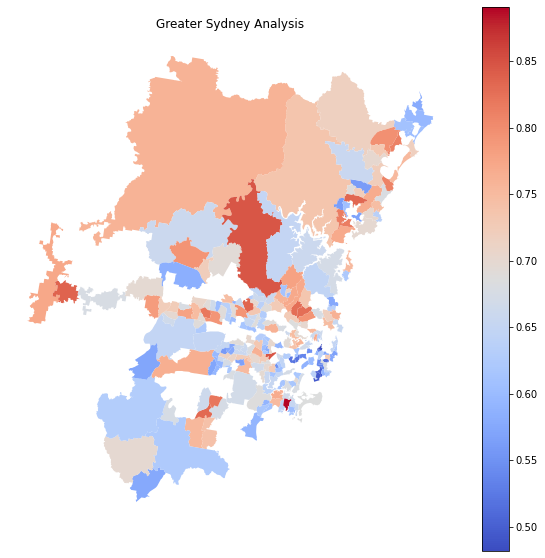

In [97]:
ax = gdf.plot(column='zscore', cmap='coolwarm', legend=True, figsize=(10, 10))
ax.set_title("Greater Sydney Analysis")
ax.set_axis_off()
plt.show()

In [98]:
print(result_df.shape)
correlation, _ = pearsonr(result_df['zscore'], result_df['median_income'])
print(f'correlation {correlation:.2f}')

(247, 12)
correlation -0.09


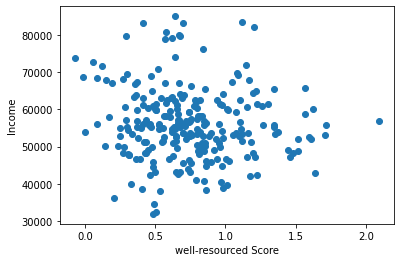

In [99]:
plt.scatter(result_df['zscore'], result_df['median_income'])
plt.xlabel('well-resourced Score')
plt.ylabel('Income')
plt.show()